# **CS4850 Data Mining Final Coursework**
#### Student: Arzaan Ul Mairaj
#### Student ID: 240280217
#### Programme: MSC AI

## Brief summary of document
This document describes the analysis of a dataset related to...

## Exploratory Data Analysis and Data Pre-processing
[_Add a short description of what is done + code blocks (with code comments as needed) related to initial loading of packages, of the data set, and your EDA + Pre-processing steps_]

In [66]:
# Pip install whatever needed
# !pip install pandas scikit-learn matplotlib imblearn

In [67]:
#import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
np.random.seed(42)

In [68]:
# Load the dataset
df = pd.read_csv("df.csv")

In [69]:
df.head()

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_epitope_id,Info_nPos,Info_nNeg,Info_cluster,Class,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,XP_805308.1:48,5693,XP_805308.1,1798,K,361766,0,1,50,1,...,-0.468073,0.116790,0.807796,-0.017825,0.319631,0.440370,0.160651,0.187754,-0.009569,-0.148201
1,XP_820569.1:60,5693,XP_820569.1,1322,T,"406333,251535","0,0","1,1",263,1,...,-0.088303,0.242516,0.351394,0.108301,0.058621,0.035160,-0.285763,-0.031222,-0.022093,-0.066371
2,XP_815900.1:8,5693,XP_815900.1,149,R,285339,0,1,197,1,...,0.121043,0.248497,0.388882,-0.257999,-0.532345,0.043773,-0.496472,0.082051,0.516216,0.131131
3,XP_821138.1:10,5693,XP_821138.1,187,E,"396765,346179","0,0","1,1",270,1,...,-0.039452,0.102934,0.039270,0.305421,0.069568,-0.207785,-0.155033,0.177424,-0.191218,-0.144111
4,XP_804893.1:6,5693,XP_804893.1,113,T,"307209,417548,272283","0,0,0","1,1,1",39,1,...,-0.074366,0.182009,0.374801,0.150980,0.063649,0.251235,-0.217734,-0.070261,NaN,0.108773


In [70]:
df.iloc[:, 10:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Columns: 1280 entries, feat_esm1b_0 to feat_esm1b_1279
dtypes: float64(1280)
memory usage: 439.5 MB


## Only one data type, float64, which is good. No need to convert any data types.

0


Class
 1    0.9836
-1    0.0164
Name: proportion, dtype: float64

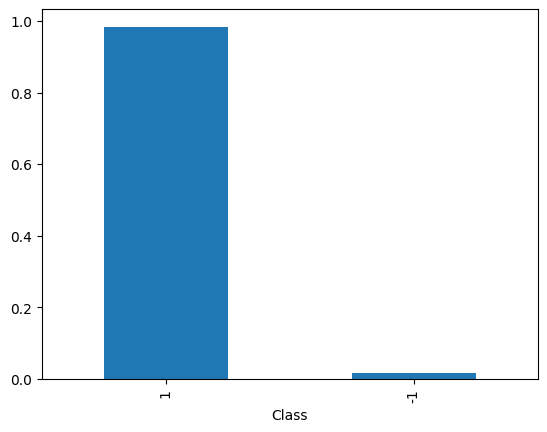

In [71]:
print(df['Class'].isna().sum())
# plot distribution of target variable
df['Class'].value_counts(normalize=True).plot(kind='bar')
df['Class'].value_counts(normalize=True)

<Axes: xlabel='Info_cluster'>

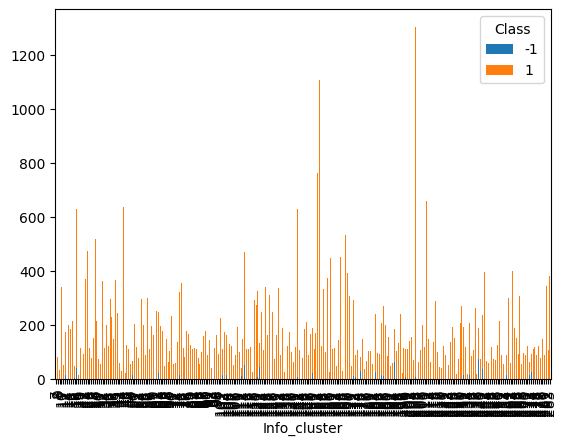

In [72]:
# check class balance across each Info_cluster
df.groupby('Info_cluster')['Class'].value_counts().unstack().plot(kind='bar', stacked=True)

## Class data is severely imbalanced, ratio of -1 to 1 is 0.02:0.98, some clusters don't even have any -1s.

In [73]:
# Info_organism_id seems repetitive, I will check if it is the same for all observations
df['Info_organism_id'].nunique()

1

In [74]:
# I'll drop Info_organism_id since it is the same for all observations, I know it will not be used in modelling anyway but I will drop it for comfort reasons since I won't have to focus on it anymore when I'm looking at the info data
df = df.drop(['Info_organism_id'], axis=1)

## Checking for missing values

<Axes: ylabel='Frequency'>

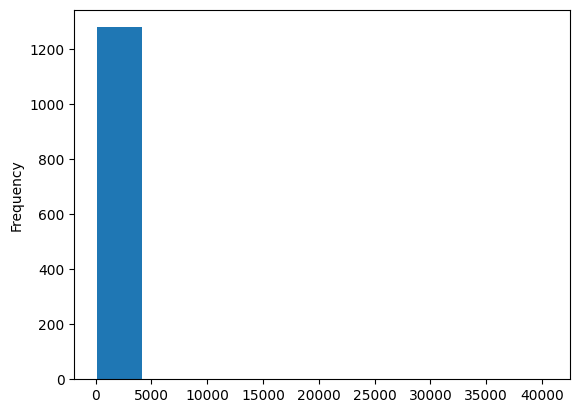

In [75]:
# checking distribution of missing values in features
df.iloc[:, 9:].isna().sum().plot(kind='hist')

## The x-axis scale goes till 40000, which means there is atleast one column with greater than or equal to 40000 missing values. I will check the statistics of missing values in features.

In [76]:
# check statistics of missing values in features
missing_values = df.iloc[:, 9:].isna().sum().tolist()

# stats of missing values
missing_values = pd.Series(missing_values)
missing_values.describe()

count     1280.000000
mean       153.371875
std       1129.557108
min        113.000000
25%        120.750000
50%        122.000000
75%        123.000000
max      40534.000000
dtype: float64

In [77]:
40534/len(df)

0.9007555555555555

## There is a column (or multiple) with most values (90%) missing. I will find and drop it/them since it will not be useful for the model.

In [78]:
#which index has max value for missing values
missing_values.idxmax()

649

In [79]:
df = df.drop(['feat_esm1b_649'], axis=1)

<Axes: ylabel='Frequency'>

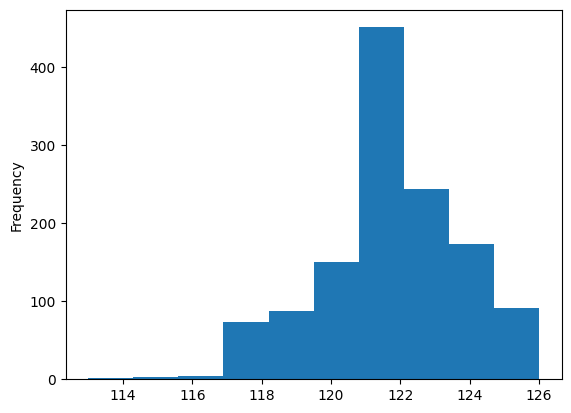

In [80]:
df.iloc[:, 9:].isna().sum().plot(kind='hist')

In [81]:
# check statistics of missing values in features
missing_values = df.iloc[:, 9:].isna().sum().tolist()

# stats of missing values
missing_values = pd.Series(missing_values)
missing_values.describe()

count    1279.000000
mean      121.799844
std         2.003276
min       113.000000
25%       120.500000
50%       122.000000
75%       123.000000
max       126.000000
dtype: float64

In [82]:
print(121.8/len(df)*100)

0.27066666666666667


# Every column has missing values and they are around 0.27% of the total values

In [83]:
# checking if any columns from df.iloc[:, 9:] have values equal to 0, since they might be missing values, as most of the columns have continuous float values so zero might be unlikely to be a value and could be a placeholder for missing values
zero_values = df.iloc[:, 9:].eq(0).sum().sum()
zero_values

np.int64(0)

1216        1
1215       10
1214       70
8           4
7          11
6          84
5         358
4        1466
3        4387
2       10138
1       15732
0       12739
Name: count, dtype: int64

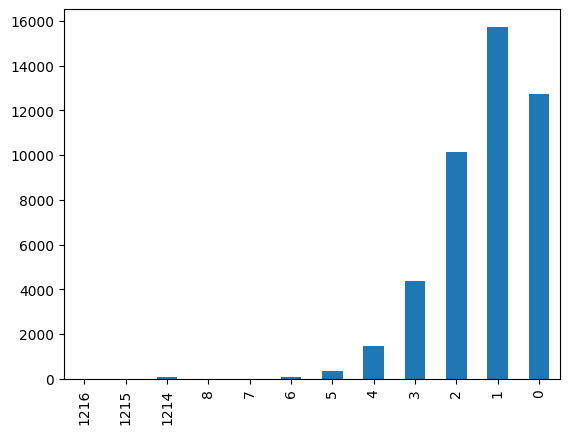

In [84]:
# how many rows have missing values
missing_rows = df.iloc[:, 9:].isna().sum(axis=1)
missing_rows.value_counts().sort_index(ascending=False).plot(kind='bar')
missing_rows.value_counts().sort_index(ascending=False)

## 1 row has 1216 missing values, 10 rows have 1215 missing values and 70 rows have 1214 missing values. I will drop these observations. The rest have very few missing values, in the range of 1-8 so I will impute them. However, I will first check if the missing values are missing at random or not.

In [85]:
# get info rows with missing values >= 1214
df[missing_rows >= 1214].iloc[:, :9]


,Info_PepID,Info_protein_id,Info_pos,Info_AA,Info_epitope_id,Info_nPos,Info_nNeg,Info_cluster,Class
238,XP_810147.1:26,XP_810147.1,577,D,405037,0,1,127,1
400,XP_820538.1:50,XP_820538.1,974,S,358318,0,1,261,1
2273,XP_805780.1:16,XP_805780.1,378,D,"401330,321238","0,0","1,1",59,1
3078,XP_812887.1:2,XP_812887.1,37,H,"338988,308215","0,0","1,1",166,1
5203,XP_821144.1:12,XP_821144.1,250,P,387019,0,1,15,1
...,...,...,...,...,...,...,...,...,...
43070,XP_819249.1:6,XP_819249.1,171,I,362595,0,1,136,1
43265,XP_812173.1:18,XP_812173.1,379,L,298135,0,1,156,1
43364,XP_809937.1:6,XP_809937.1,45,Q,306044,0,1,124,1
44526,XP_820304.1:22,XP_820304.1,425,L,328759,0,1,63,1


In [86]:
print(df[missing_rows >= 1214].iloc[:, :9].nunique())
print(df.iloc[:, :9].nunique())

Info_PepID         81
Info_protein_id    72
Info_pos           81
Info_AA            20
Info_epitope_id    81
Info_nPos           5
Info_nNeg           5
Info_cluster       69
Class               2
dtype: int64
Info_PepID          4208
Info_protein_id      409
Info_pos            3169
Info_AA               20
Info_epitope_id    12441
Info_nPos             23
Info_nNeg             21
Info_cluster         265
Class                  2
dtype: int64


# Upon comparing the unique values of the info columns of the rows with 1214 or more missing values with the unique values of the info columns of the whole dataset, I can see that the rows with 1214 or more missing values are reasonably random and I can drop these rows.

In [87]:
# drop rows with 1214 or more missing values
df = df.drop(df[missing_rows >= 1214].index)
print(len(df))

44919


## Handling duplicate rows

In [88]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

In [89]:
# Getting duplicates based on ID columns
df[['Info_PepID', 'Info_protein_id', 'Info_epitope_id']].duplicated().sum()

np.int64(32484)

## Without domain knowledge, I cannot say if the duplicates are valid or not. I will keep them for now. They also do comprise a large portion of the dataset, so they might be valid. I'll now check if there are any columns that have relatively low variance compared to others.

<Axes: >

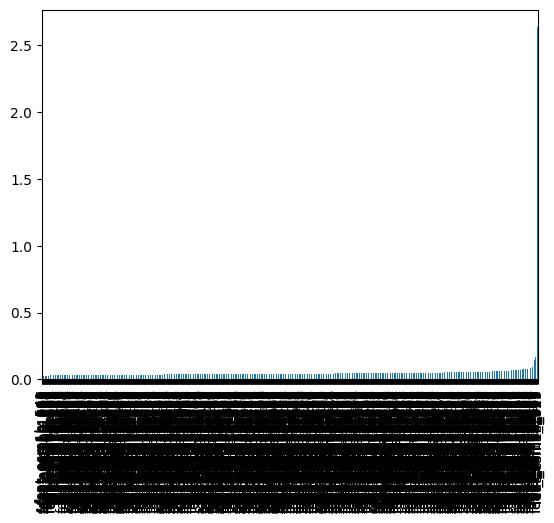

In [90]:
variances = df.iloc[:, 9:].var().sort_values()
variances.sort_values().plot(kind='bar')

## There does seem to be a column with high variance, but most columns are similar in variance with none being too low compared to the others, so I'll let it be for now.

## Splitting the data before imputing missing values

In [91]:
# Using GroupShuffleSplit to split the data by Info_cluster so that the clusters are not split between train and test
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Info_cluster'])) # split by cluster, not by individual
train_df = df.iloc[train_idx]
X_test = df.iloc[test_idx]
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=6)
train_idx, val_idx = next(gss.split(train_df, groups=train_df['Info_cluster'])) # split by cluster, not by individual
X_train = train_df.iloc[train_idx]
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)
X_val = train_df.iloc[val_idx]
y_val = X_val['Class']
X_val = X_val.drop(['Class'], axis=1)

In [92]:
len(X_train)

27581

In [93]:
y_train.value_counts(normalize=True)

Class
 1    0.983539
-1    0.016461
Name: proportion, dtype: float64

In [94]:
y_val.value_counts(normalize=True)

Class
 1    0.981929
-1    0.018071
Name: proportion, dtype: float64

In [95]:
y_test.value_counts(normalize=True)

Class
 1    0.985072
-1    0.014928
Name: proportion, dtype: float64

## The class imbalance is sufficiently maintained in the train and test splits.

In [96]:
# making sure the split is correct
train_clusters = X_train['Info_cluster'].unique()
test_clusters = X_test['Info_cluster'].unique()
val_clusters = X_val['Info_cluster'].unique()
print(len(set(train_clusters) & set(test_clusters) & set(val_clusters))) # should be 0 since & is intersection

0


In [97]:
X_train = X_train.iloc[:, 7:]
X_val = X_val.iloc[:, 7:]
X_test = X_test.iloc[:, 7:]

## I was going to impute missing values using Stochastic Regression Imputation or even just KNN but the sheer volume of the dataset makes it computationally expensive. Hence, I'll just use mean imputation for now.

In [98]:
# impute missing values with mean
X_train.iloc[:, 1:] = X_train.iloc[:, 1:].fillna(X_train.iloc[:, 1:].mean())
X_val.iloc[:, 1:] = X_val.iloc[:, 1:].fillna(X_train.iloc[:, 1:].mean()) # using train mean to impute val to avoid data leakage
X_test.iloc[:, 1:] = X_test.iloc[:, 1:].fillna(X_train.iloc[:, 1:].mean()) # using train mean to impute test to avoid data leakage

## Checking scale of data

In [99]:
min_values = X_train.iloc[:, 1:].min().values
max_values = X_train.iloc[:, 1:].max().values

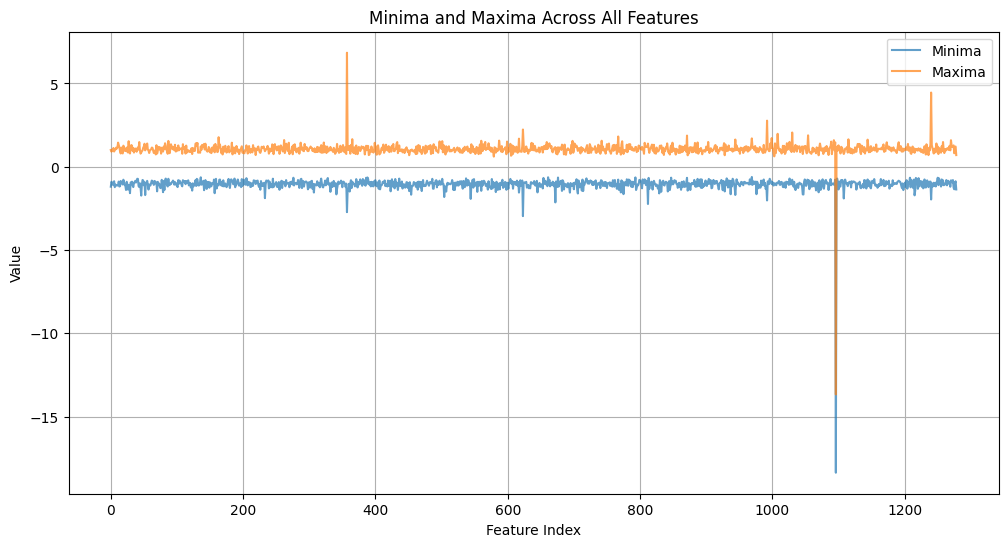

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(min_values, label='Minima', alpha=0.7)
plt.plot(max_values, label='Maxima', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.title('Minima and Maxima Across All Features')
plt.legend()
plt.grid(True)
plt.show()

## The scale of the data is different across some features. I will scale the data, but not before dealing with outliers. Since the data is so large, I can't use graphical methods to detect outliers. I will use isolation forest to detect outliers.

In [101]:
X_y_train = X_train.copy()
X_y_train['Class'] = y_train

In [102]:
# Initialize Isolation Forest
iso_forest = IsolationForest(
    random_state=42,
    n_jobs=-1
)

outlier_preds = iso_forest.fit_predict(X_y_train.iloc[:, 1:-1])

X_y_train['is_not_outlier'] = outlier_preds

is_not_outlier
 1    0.958305
-1    0.041695
Name: proportion, dtype: float64


is_not_outlier
 1    26431
-1     1150
Name: count, dtype: int64

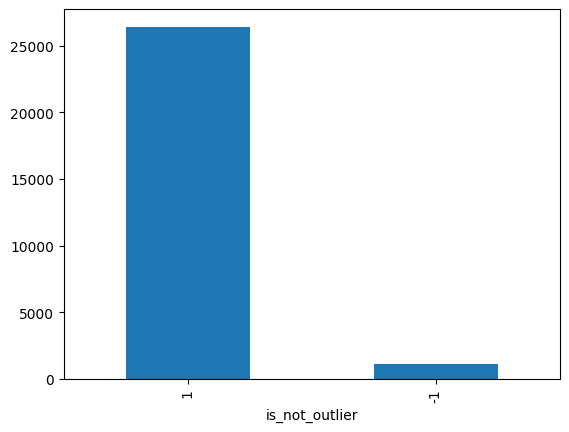

In [103]:
# Check how many outliers were detected
X_y_train['is_not_outlier'].value_counts().plot(kind='bar')
print(X_y_train['is_not_outlier'].value_counts(normalize=True))
X_y_train['is_not_outlier'].value_counts()

## Since the outliers are only ~4.2% of the data, I will remove them and then scale the data. When you don't pass in the contamination parameter, the thresholding is done according to what is the method in the paper.


In [40]:
X_y_train = X_y_train[X_y_train['is_not_outlier'] == 1]
X_y_train = X_y_train.drop(['is_not_outlier'], axis=1)
X_train = X_y_train.iloc[:, :-1]
y_train = X_y_train['Class']

In [41]:
# Scaling
scaler = StandardScaler()
X_train.iloc[:,1:] = scaler.fit_transform(X_train.iloc[:, 1:])
X_val.iloc[:,1:] = scaler.transform(X_val.iloc[:, 1:])
X_test.iloc[:,1:] = scaler.transform(X_test.iloc[:, 1:])

In [42]:
X_train

,Info_cluster,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,50,0.703129,-0.673589,-0.240686,-2.412645,-1.814724,1.786330,0.726708,-1.250825,2.915206,...,-1.985388,-0.615524,2.076479,-0.102806,1.592264,2.122277,1.768951,1.013956,-0.698582,-1.238423
3,270,1.436325,-0.510360,-1.061137,-1.534090,0.159890,0.922832,-0.817089,-0.431403,0.983145,...,0.400979,-0.681244,-1.141667,1.335830,0.374662,-1.573692,0.238369,0.961145,-1.480292,-1.212630
4,39,-1.545342,0.707956,0.853994,-0.466215,-0.450106,2.121188,-0.828514,0.643322,-0.298001,...,0.206595,-0.306192,0.263344,0.648475,0.345844,1.043775,-0.065636,-0.305132,0.019554,0.382129
6,195,-0.713651,-0.956238,0.093647,0.762506,0.868587,0.150905,-0.703919,-0.635207,1.010559,...,0.944598,0.416726,-1.166796,2.386114,0.091970,0.311595,-1.240981,0.886433,-1.080875,0.909661
8,205,-0.986917,-0.012721,1.103249,0.991632,0.268670,1.386520,-1.509398,1.065096,-0.198550,...,-0.359061,-0.241164,-1.343564,0.024583,1.521537,-2.874805,-0.282505,-0.293475,-0.538889,0.429641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,191,-0.481926,0.312967,2.738800,-0.574085,0.753938,0.621002,-0.708091,0.648469,-1.050976,...,-1.026048,0.071114,0.132653,-1.273790,-0.942774,-0.646169,-0.265622,-0.559757,-0.259629,1.218408
44991,150,-0.085576,-0.036881,-0.285631,0.564408,-1.560728,0.581463,-0.492432,0.813082,-0.017568,...,0.008410,0.910939,-0.300417,0.428526,1.565614,0.409287,-0.523657,-0.307636,-0.331801,-0.911205
44992,96,1.177481,-0.521606,1.157800,0.713100,-0.775492,0.507746,-0.097284,0.833480,-0.681896,...,0.343070,-0.102166,-1.546240,1.861111,-0.242822,1.981336,0.036502,0.116577,0.208161,0.819154
44996,8,-1.297619,-0.566434,-0.476928,0.391359,0.446431,-1.305629,-0.858833,-1.313224,1.264653,...,2.123250,-0.526296,0.564716,-0.094495,0.462329,-0.859518,0.518446,-1.570101,-0.824996,-0.212871


# Features are now scaled

## Feature reduction: PCA. Again, because of the size of the dataset, I will use PCA to reduce the number of features. Let's first see how many components can explain 90% of the variance

In [43]:
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train.iloc[:, 1:])
len(pca.explained_variance_ratio_)

606

# 90% of the variance can be explained by 606 components, which is around half the original dimensions. I'll now use the Kaiser criterion to see how many components have eigenvalues greater than 1. Then, I'll inspect using a Scree plot as well to see how many components I should use. 

In [44]:
pca = PCA(random_state=42).fit(X_train.iloc[:, 1:])
eigenvalues = pca.explained_variance_  # Get eigenvalues
np.where(eigenvalues < 1)[0][0]

np.int64(195)

## I will now use a Scree plot for 195 components to see how many components I should use. The Kaiser retains quite a lot of components but it's a good starting point.

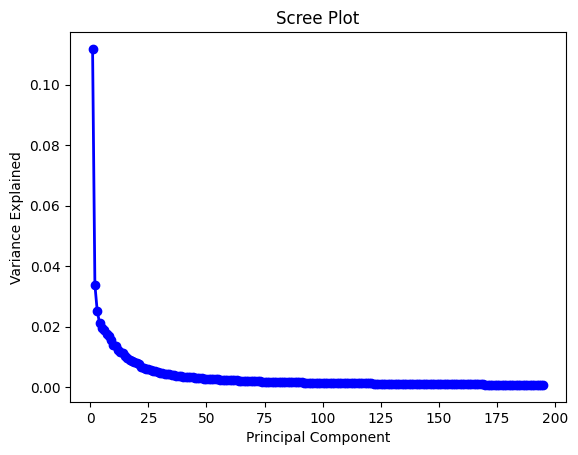

In [45]:
pca = PCA(random_state=42, n_components=195).fit(X_train.iloc[:, 2:])
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## From the scree plot, it can be seen that the elbow is between 0 and 15 components. I will make the plot again for the first 50 components to see if I can get a better estimate.

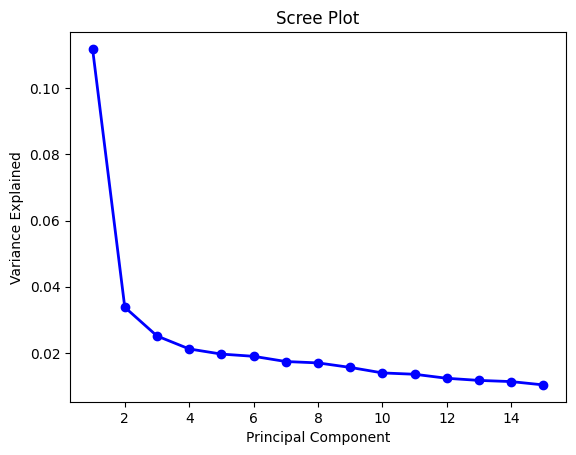

In [46]:
pca = PCA(random_state=42, n_components=15).fit(X_train.iloc[:, 2:])
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## As the elbow is on 3, I will use 3 components for PCA

In [47]:
X_train

,Info_cluster,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,50,0.703129,-0.673589,-0.240686,-2.412645,-1.814724,1.786330,0.726708,-1.250825,2.915206,...,-1.985388,-0.615524,2.076479,-0.102806,1.592264,2.122277,1.768951,1.013956,-0.698582,-1.238423
3,270,1.436325,-0.510360,-1.061137,-1.534090,0.159890,0.922832,-0.817089,-0.431403,0.983145,...,0.400979,-0.681244,-1.141667,1.335830,0.374662,-1.573692,0.238369,0.961145,-1.480292,-1.212630
4,39,-1.545342,0.707956,0.853994,-0.466215,-0.450106,2.121188,-0.828514,0.643322,-0.298001,...,0.206595,-0.306192,0.263344,0.648475,0.345844,1.043775,-0.065636,-0.305132,0.019554,0.382129
6,195,-0.713651,-0.956238,0.093647,0.762506,0.868587,0.150905,-0.703919,-0.635207,1.010559,...,0.944598,0.416726,-1.166796,2.386114,0.091970,0.311595,-1.240981,0.886433,-1.080875,0.909661
8,205,-0.986917,-0.012721,1.103249,0.991632,0.268670,1.386520,-1.509398,1.065096,-0.198550,...,-0.359061,-0.241164,-1.343564,0.024583,1.521537,-2.874805,-0.282505,-0.293475,-0.538889,0.429641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,191,-0.481926,0.312967,2.738800,-0.574085,0.753938,0.621002,-0.708091,0.648469,-1.050976,...,-1.026048,0.071114,0.132653,-1.273790,-0.942774,-0.646169,-0.265622,-0.559757,-0.259629,1.218408
44991,150,-0.085576,-0.036881,-0.285631,0.564408,-1.560728,0.581463,-0.492432,0.813082,-0.017568,...,0.008410,0.910939,-0.300417,0.428526,1.565614,0.409287,-0.523657,-0.307636,-0.331801,-0.911205
44992,96,1.177481,-0.521606,1.157800,0.713100,-0.775492,0.507746,-0.097284,0.833480,-0.681896,...,0.343070,-0.102166,-1.546240,1.861111,-0.242822,1.981336,0.036502,0.116577,0.208161,0.819154
44996,8,-1.297619,-0.566434,-0.476928,0.391359,0.446431,-1.305629,-0.858833,-1.313224,1.264653,...,2.123250,-0.526296,0.564716,-0.094495,0.462329,-0.859518,0.518446,-1.570101,-0.824996,-0.212871


In [48]:
pca = PCA(random_state=42, n_components=3)
X_train_pca = pca.fit_transform(X_train.iloc[:, 1:])
X_val_pca = pca.transform(X_val.iloc[:, 1:])
X_test_pca = pca.transform(X_test.iloc[:, 1:])

In [49]:
X_train_pca

array([[ -5.90263686,  -0.0462577 ,  -6.99137706],
       [-10.70735668,   2.84827639,  -6.57904161],
       [ -8.01091092,   3.2268985 ,   2.96541157],
       ...,
       [ -9.89032131,   2.368599  ,   1.91437654],
       [ -2.26031748,   1.44203676,  -2.34830833],
       [-10.64286281,   1.18793078,  -5.50519662]], shape=(26431, 3))

In [329]:
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df['Info_cluster'] = X_train['Info_cluster'].values
X_train_pca_df.to_csv('X_train_pca.csv', index=False)
X_val_pca_df = pd.DataFrame(X_val_pca)
X_val_pca_df.to_csv('X_val_pca.csv', index=False)
X_test_pca_df = pd.DataFrame(X_test_pca)
X_test_pca_df.to_csv('X_test_pca.csv', index=False)
y_train_df = pd.DataFrame(y_train)
y_train_df.to_csv('y_train.csv', index=False)
y_val_df = pd.DataFrame(y_val)
y_val_df.to_csv('y_val.csv', index=False)
y_test_df = pd.DataFrame(y_test)
y_test_df.to_csv('y_test.csv', index=False)

In [7]:
# read
X_train_pca = pd.read_csv('X_train_pca.csv')
X_val_pca = pd.read_csv('X_val_pca.csv')
X_test_pca = pd.read_csv('X_test_pca.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')



# Since the classes are imbalanced, I'll check which sampling method works best for the imbalanced data, using a baseline model of logistic regression.

In [9]:
# random undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_pca, y_train)
train_data_us = pd.DataFrame(X_resampled)
y_us = y_resampled.copy()

# random oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_pca, y_train)
train_data_os = pd.DataFrame(X_resampled)
y_os = y_resampled.copy()

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_pca, y_train)
train_data_smote = pd.DataFrame(X_resampled)
y_smote = y_resampled.copy()

# I will now fit a logistic regression model to the data and check the balanced accuracy for each sampling method. I'll also try a cost sensitive logistic regression model.

In [371]:
def balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    print("TP:", tp, "FP:", fp, "TN:", tn, "FN:", fn)
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    return (specificity + sensitivity) / 2

lr = LogisticRegression(random_state=41, n_jobs=-1, solver='saga')
lr.fit(train_data_us.iloc[:, :-1], y_us)
y_pred = lr.predict(X_val_pca)
print("Random undersampling balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = lr.predict(train_data_us.iloc[:, :-1])
print("Random undersampling balanced accuracy on train data:", balanced_accuracy(y_us, y_pred))
print()
lr = LogisticRegression(random_state=41, n_jobs=-1, solver='saga')
lr.fit(X_train_pca.iloc[:,:-1], y_train)
y_pred = lr.predict(X_val_pca)
print("Non-sampled balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = lr.predict(X_train_pca.iloc[:,:-1])
print("Non-sampled balanced accuracy on train data:", balanced_accuracy(y_train, y_pred))
print()
print()
lr = LogisticRegression(random_state=41, n_jobs=-1, solver='saga')
lr.fit(train_data_os.iloc[:, :-1], y_os)
y_pred = lr.predict(X_val_pca)
print("Random oversampling balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = lr.predict(train_data_os.iloc[:, :-1])
print("Random oversampling balanced accuracy on train data:", balanced_accuracy(y_os, y_pred))
print()
print()
lr = LogisticRegression(random_state=41, n_jobs=-1, solver='saga')
lr.fit(train_data_smote.iloc[:, :-1], y_smote)
y_pred = lr.predict(X_val_pca)
print("SMOTE balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = lr.predict(train_data_smote.iloc[:, :-1])
print("SMOTE balanced accuracy on train data:", balanced_accuracy(y_smote, y_pred))
print()
print()
lr = LogisticRegression(random_state=41, class_weight='balanced', n_jobs=-1, solver='saga')
lr.fit(X_train_pca.iloc[:,:-1], y_train)
y_pred = lr.predict(X_val_pca)
print("Cost-sensitive Balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = lr.predict(X_train_pca.iloc[:,:-1])
print("Cost-sensitive Balanced accuracy on train data:", balanced_accuracy(y_train, y_pred))

TP: 4733 FP: 82 TN: 57 FN: 2820
Specificity: 0.41007194244604317
Sensitivity: 0.6266384218191448
Random undersampling balanced accuracy: 0.518355182132594
TP: 285 FP: 257 TN: 181 FN: 153
Specificity: 0.4132420091324201
Sensitivity: 0.6506849315068494
Random undersampling balanced accuracy on train data: 0.5319634703196348

TP: 7553 FP: 139 TN: 0 FN: 0
Specificity: 0.0
Sensitivity: 1.0
Non-sampled balanced accuracy: 0.5
TP: 25993 FP: 438 TN: 0 FN: 0
Specificity: 0.0
Sensitivity: 1.0
Non-sampled balanced accuracy on train data: 0.5


TP: 4877 FP: 85 TN: 54 FN: 2676
Specificity: 0.38848920863309355
Sensitivity: 0.645703693896465
Random oversampling balanced accuracy: 0.5170964512647793
TP: 16256 FP: 15368 TN: 10625 FN: 9737
Specificity: 0.40876389797253104
Sensitivity: 0.6253991459239026
Random oversampling balanced accuracy on train data: 0.5170815219482168


TP: 3799 FP: 66 TN: 73 FN: 3754
Specificity: 0.5251798561151079
Sensitivity: 0.5029789487620813
SMOTE balanced accuracy: 0.5140794

## I printed out the train balanced accuracies as well to check for overfitting. Specificity and sensitivity are inversely related, so it is better that I choose the balanced accuracy that comes not from one value being 0 and the other 1. The highest balanced accuracy for validation data comes from Random Undersampling so I will use that for the final model.

## Model fitting

## I will be trying out a few models. Logistic regression, Random Forest and XGBoost. I will first try out the models with default parameters, choosing the good performing models based on the balanced accuracy on the validation set and then tune the hyperparameters for them.

In [10]:
def balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    return (specificity + sensitivity) / 2

In [393]:
X_val_pca

In [398]:
lr = LogisticRegression(random_state=41, n_jobs=-1, solver='saga')
lr.fit(train_data_us.iloc[:, :-1], y_us)
y_pred = lr.predict(X_val_pca)
print("Logistic Regression balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = lr.predict(train_data_us.iloc[:, :-1])
print("Logistic Regression balanced accuracy on train data:", balanced_accuracy(y_us, y_pred))


rf = RandomForestClassifier(random_state=41, n_jobs=-1, class_weight='balanced')
rf.fit(train_data_us.iloc[:, :-1], y_us)
y_pred = rf.predict(X_val_pca)
print("Random Forest balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = rf.predict(train_data_us.iloc[:, :-1])
print("Random Forest balanced accuracy on train data:", balanced_accuracy(y_us, y_pred))


xgb = XGBClassifier(random_state=41, n_jobs=-1)
xgb_y_train = y_us.replace(-1, 0)
xgb.fit(train_data_us.iloc[:, :-1], xgb_y_train)
y_pred = xgb.predict(X_val_pca)
xgb_y_val = y_val.replace(-1, 0)
print("XGBoost balanced accuracy:", balanced_accuracy(xgb_y_val, y_pred))
y_pred = xgb.predict(train_data_us.iloc[:, :-1])
print("XGBoost balanced accuracy on train data:", balanced_accuracy(xgb_y_train, y_pred))

Logistic Regression balanced accuracy: 0.518355182132594
Logistic Regression balanced accuracy on train data: 0.5319634703196348
Random Forest balanced accuracy: 0.49318008852549894
Random Forest balanced accuracy on train data: 1.0
XGBoost balanced accuracy: 0.49183372751024657
XGBoost balanced accuracy on train data: 0.9920091324200913


## Logistic Regression is the only model that is not overfitting. I will now tune the hyperparameters for it.

In [29]:
# I will now tune all the models using grid search.
def balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return (specificity + sensitivity) / 2

scorer = make_scorer(balanced_accuracy, greater_is_better=True)

gkf = GroupKFold(n_splits=5)

params = {
        "penalty": ["l1", "l2", "elasticnet", None],  # Regularization type
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization strength
    "solver": ["liblinear", "lbfgs", "newton-cg", "saga"],  # Optimization solver
    "max_iter": [100, 200, 500, 1000, 5000],  # Maximum iterations
    "fit_intercept": [True, False],  # Whether to include an intercept
    "class_weight": [None, "balanced"],  # Handling imbalanced datasets
    "tol": [1e-4, 1e-3, 1e-2, 1e-1],  # Tolerance for stopping criteria
    "dual": [True, False],  # Dual formulation (only for l2 penalty)
    "l1_ratio": [0.1, 0.5, 0.9],  # ElasticNet mixing ratio (only for saga + elasticnet)
    "warm_start": [True, False],  # Use previous solution as initialization
    "intercept_scaling": [0.1, 1, 10],  # Scaling of intercept (only for liblinear)
}

In [399]:
#Logistic Regression
lr = LogisticRegression(random_state=41, n_jobs=-1)
#scoring to be done by balanced accuracy function defined above
lr_search = RandomizedSearchCV(lr, params, n_iter=50, scoring=scorer, n_jobs=-1, cv=gkf, random_state=42)
lr_search.fit(train_data_us.iloc[:, :-1], y_us, groups=train_data_us['Info_cluster'])
print("Logistic Regression best params:", lr_search.best_params_)
print("Logistic Regression best score:", lr_search.best_score_)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/

Logistic Regression best params: {'warm_start': True, 'tol': 0.01, 'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'l1_ratio': 0.9, 'intercept_scaling': 0.1, 'fit_intercept': False, 'dual': False, 'C': 0.01}
Logistic Regression best score: 0.5240903547295965


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'lib

In [14]:
lr = LogisticRegression(random_state=41, n_jobs=-1, **lr_search.best_params_)
lr.fit(train_data_us.iloc[:, :-1], y_us)
y_pred = lr.predict(X_val_pca)
print("Logistic Regression balanced accuracy:", balanced_accuracy(y_val, y_pred))
y_pred = lr.predict(train_data_us.iloc[:, :-1])
print("Logistic Regression balanced accuracy on train data:", balanced_accuracy(y_us, y_pred))

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TP: 5792 FP: 87 TN: 57 FN: 3710
Specificity: 0.3958333333333333
Sensitivity: 0.6095558829720059
Logistic Regression balanced accuracy: 0.5026946081526696
TP: 286 FP: 257 TN: 181 FN: 152
Specificity: 0.4132420091324201
Sensitivity: 0.6529680365296804
Logistic Regression balanced accuracy on train data: 0.5331050228310502


## Consolidate the Data Mining Pipeline 

In [18]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, GroupKFold

def balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    print("TP:", tp, "FP:", fp, "TN:", tn, "FN:", fn)
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    return (specificity + sensitivity) / 2

class DropInfoCluster(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = None
        
    def fit(self, X, y=None):
        return self.fit_transform(X, y)
    
    def fit_transform(self, X, y=None):
        return X.drop('Info_cluster', axis=1)

    def transform(self, X):
        return X.drop('Info_cluster', axis=1)
    
class Imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.fill_values_ = None
        
    def fit(self, X, y=None):
        return self.fit_transform(X, y)
    
    def fit_transform(self, X, y):
        self.fill_values_ = X.mean()
        X = X.fillna(self.fill_values_)
        return X

    def transform(self, X):
        X = X.fillna(self.fill_values_)
        return X

# Custom Transformer for Outlier Removal
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, type='standard'):
        self.type = type
        self.iso_forest = IsolationForest(random_state=42, n_jobs=-1)
        self.scaler = None

        
    def fit(self, X, y=None):
        return self.fit_transform(X, y)

    def fit_transform(self, X, y):
        if self.type == 'standard':
            self.scaler = StandardScaler()
        elif self.type == 'robust':
            self.scaler = RobustScaler()
        
        outlier_preds = self.iso_forest.fit_predict(X)
        X['is_not_outlier'] = outlier_preds
        
        no_outliers = X[X['is_not_outlier'] == 1]
        no_outliers = no_outliers.drop(['is_not_outlier'], axis=1)
        
        # Fit the scaler
        self.scaler.fit(no_outliers)
        transformed = self.scaler.transform(X.iloc[:, :-1])
        transformed = pd.DataFrame(transformed, columns=X.columns[:-1])
        transformed['is_not_outlier'] = X['is_not_outlier'].values
        
        
        return transformed

    def transform(self, X):
        transformed = self.scaler.transform(X)
        transformed = pd.DataFrame(transformed, columns=X.columns)
            
        return transformed
    
class PCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pca = PCA(n_components=3, random_state=42)
        
    def fit(self, X, y=None):
        return self.fit_transform(X, y)

    def fit_transform(self, X, y=None):
        data = X[X['is_not_outlier'] == 1]
        data = data.drop(['is_not_outlier'], axis=1)
        self.pca.fit(data)
        transformed = self.pca.transform(X.iloc[:, :-1])
        transformed=pd.DataFrame(transformed, columns=[f'PC{i+1}' for i in range(transformed.shape[1])])
        transformed['is_not_outlier'] = X['is_not_outlier'].values
        
        return transformed

    def transform(self, X):  

        transformed = self.pca.transform(X)
        transformed=pd.DataFrame(transformed, columns=[f'PC{i+1}' for i in range(transformed.shape[1])])
            
        return transformed
    
class UnderSampleAndLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.params = {'warm_start': True, 'tol': 0.01, 'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'l1_ratio': 0.9, 'intercept_scaling': 0.1, 'fit_intercept': False, 'dual': False, 'C': 0.01}
        self.lr = LogisticRegression(random_state=41, n_jobs=-1, **self.params)
        self.rus = RandomUnderSampler(random_state=42)
        
    def fit(self, X, y=None):
        return self.fit_transform(X,y)
    
    def transform(self, X):
        pass
        
    def fit_transform(self, X, y):
        # get indices where is_not_outlier == 1
        X['Class'] = y.tolist()
        
        X = X[X['is_not_outlier'] == 1]
        X = X.drop(['is_not_outlier'], axis=1)
        
        y = X['Class']
        X = X.drop(['Class'], axis=1)
        
        X, y = self.rus.fit_resample(X, y)
        X = pd.DataFrame(X)
        
        self.lr.fit(X, y)

        return self

    def predict(self, X):
        return self.lr.predict(X)

    def predict_proba(self, X):
        return self.lr.predict_proba(X)

# Load Data
df = pd.read_csv("df.csv")
df=df.drop(['Info_PepID', 'Info_organism_id', 'Info_protein_id', 'Info_pos',
       'Info_AA', 'Info_epitope_id', 'Info_nPos', 'Info_nNeg', 'Info_organism_id', 'feat_esm1b_649'], axis=1)

missing_rows = df.isna().sum(axis=1)
df= df.drop(df[missing_rows >= 1214].index)

# Using GroupShuffleSplit to split the data by Info_cluster so that the clusters are not split between train and test
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Info_cluster'])) # split by cluster, not by individual
train_df = df.iloc[train_idx]
X_test = df.iloc[test_idx]
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=6)
train_idx, val_idx = next(gss.split(train_df, groups=train_df['Info_cluster'])) # split by cluster, not by individual
X_train = train_df.iloc[train_idx]
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)

# Define Pipeline with Logistic Regression
pipeline = Pipeline([
    ('dropcolumns', DropInfoCluster()),
    ('impute', Imputer()),  # Fill missing values with mean
    ('scaler', Scaler()),  # Scale features
    ('pca', PCATransformer()),  # Reduce dimensionality
    ('undersampleAndlogreg', UnderSampleAndLogisticRegression(
    )) 
])

gkf = GroupKFold(n_splits=5)

param_grid = {
    'scaler__type': ['standard', 'robust', 'minmax'],
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(balanced_accuracy, greater_is_better=True),  # or a custom scorer
    cv=gkf,
    n_jobs=-1
)
grid_search.fit(X_train, y_train, groups=X_train['Info_cluster'])
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_93796/4256672866.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_93796/4256672866.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_93796/4256672866.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

TP: 3136 FP: 12 TN: 11 FN: 2365
Specificity: 0.4782608695652174
Sensitivity: 0.5700781676058898
[CV] END ..............................scaler__type=standard; total time= 1.3min
[CV] END ................................scaler__type=minmax; total time=  23.4s
TP: 3281 FP: 46 TN: 28 FN: 2161
Specificity: 0.3783783783783784
Sensitivity: 0.6029033443586916


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/

TP: 2969 FP: 23 TN: 17 FN: 2503
Specificity: 0.425
Sensitivity: 0.5425804093567251
[CV] END ................................scaler__type=robust; total time= 1.3min
[CV] END ................................scaler__type=minmax; total time=  25.3s
TP: 3136 FP: 12 TN: 11 FN: 2365
Specificity: 0.4782608695652174
Sensitivity: 0.5700781676058898
TP: 3099 FP: 87 TN: 63 FN: 2267
Specificity: 0.42
Sensitivity: 0.5775251584047708


/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_93796/4256672866.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['is_not_outlier'] = outlier_preds
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
Python(96554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best params: {'scaler__type': 'robust'}
Best score: 0.5011996078725078


Python(96555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


## Performance evaluation on test split
[_Evaluate the performance of your final pipeline on the final test split. You can report many different performance metrics, but don't forget to report the main one (see the CW brief for details)_]

In [22]:
pipeline = Pipeline([
    ('dropcolumns', DropInfoCluster()),
    ('impute', Imputer()),  # Fill missing values with mean
    ('scaler', Scaler(type='robust')),  # Scale features
    ('pca', PCATransformer()),  # Reduce dimensionality
    ('undersampleAndlogreg', UnderSampleAndLogisticRegression(
    )) 
])
pipeline.fit_transform(X_train, y_train)
pipeline.transform(X_test)

y_pred = pipeline.predict(X_test)
balanced_accuracy(y_test, y_pred)

/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_93796/4256672866.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['is_not_outlier'] = outlier_preds
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


TP: 5778 FP: 86 TN: 58 FN: 3724
Specificity: 0.4027777777777778
Sensitivity: 0.6080825089454852


/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


np.float64(0.5054301433616315)

## Generation of predictions on holdout set

In [32]:
holdout = pd.read_csv("df_holdout.csv")
holdout_copy = holdout.drop(['Info_PepID', 'Info_organism_id', 'Info_protein_id', 'Info_pos',
       'Info_AA', 'Info_epitope_id', 'Info_nPos', 'Info_nNeg', 'Info_organism_id', 'feat_esm1b_649'], axis=1)
pipeline.transform(holdout_copy)
y_pred = pipeline.predict(holdout_copy)
holdout['Prediction'] = y_pred.tolist()
holdout = holdout[['Info_PepID', 'Info_pos', 'Prediction']]
holdout.to_csv('holdout_predictions.csv', index=False)

/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/arzaan/PycharmProjects/ComputationalIntelligence/venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## References
[_If you cited any specific references in this doc, please add them here._]